<a href="https://colab.research.google.com/github/mohmiim/MLIntroduction/blob/master/session-6/UniSingleForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [29]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/mohmiim/MLIntroduction/master/session-6/data/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-02-06 19:20:43--  https://raw.githubusercontent.com/mohmiim/MLIntroduction/master/session-6/data/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.03s   

2020-02-06 19:20:43 (2.47 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
def showSeries(time, series, show=True):
    plt.plot(time, series)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [0]:
def loadData(pathToFile,sampleCount=None, timeIndex = 0 , dataIndex=1):
    time = []
    data = []
    plt.figure(figsize=(10, 6))
    with open(pathToFile) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            data.append(float(row[dataIndex]))
            time.append(int(row[timeIndex]))
    
    series = np.array(data)
    time = np.array(time)
    if sampleCount != None :
        train, valid = split(sampleCount, series)
        ttrain, tvalid = split(sampleCount, time)
        showSeries(ttrain, train, show=False)
        showSeries(tvalid, valid)
        return ttrain, train , tvalid, valid
    else :
        showSeries(time, series)
        return time,series

In [0]:
def split(sampleCount, series):
    X_train = series[:sampleCount]
    X_valid = series[sampleCount:]
    return X_train, X_valid

In [0]:
def sequenceData(train,window_size, output=True, shuffle= True) :
    if output : window_size = window_size + 1
    dataset = tf.data.Dataset.from_tensor_slices(train)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle :
        dataset = dataset.shuffle(1000)
    
    X = []
    y = []
    if output :
        dataset = dataset.map(lambda w: (w[:-1], w[-1:]))
        for a,b in dataset:
            X.append(a.numpy())
            y.append(b.numpy())
    else :
        for f in dataset :
            X .append(f.numpy())
    return np.asarray(X), np.asarray(y)

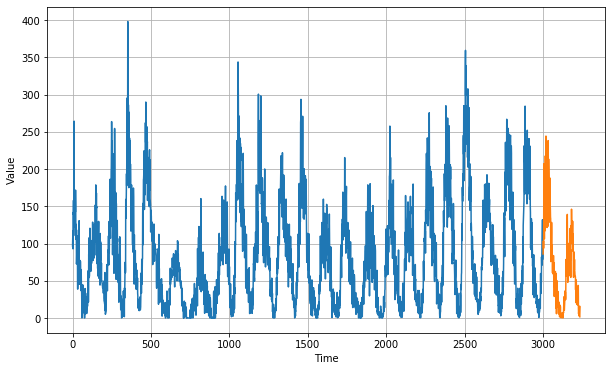

In [35]:
DATA_FILE = "data/Sunspots.csv"
#time_train, train, time_valid, valid = loadData("data/Sunspots.csv",3000, 0, 2)
time_train, train, time_valid, valid = loadData("/tmp/sunspots.csv",3000, 0, 2)
train_mean = train.mean()
train_std = train.std()


In [0]:
from tensorflow.keras.layers import LSTM,Conv1D,Dense,MaxPooling1D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np

In [37]:
# constants
EPOCHS = 300
BATCH_SIZE = 200
window_size = 60
FILTERS_COUNT = 128
KERNER_SIZE = 5
NODES = 150
shuffle_buffer_size = 1000
print(time_train.shape)
print(train.shape)
print(time_valid.shape)
print(valid.shape)

(3000,)
(3000,)
(235,)
(235,)


In [0]:
X_train, y_train = sequenceData(train,window_size)

X_train = (X_train-train_mean)/train_std
y_train = (y_train-train_mean)/train_std

print(X_train.shape)
print(y_train.shape)
print(train_mean)
print(train_std)

(2940, 60)
(2940, 1)
83.20666666666666
68.41171704385798


In [0]:
def createConvLstmModel() :
  model = Sequential()
  model.add(Conv1D(FILTERS_COUNT, KERNER_SIZE, activation='relu', input_shape=(window_size,1)))
  model.add(MaxPooling1D())
  model.add(Conv1D(FILTERS_COUNT, KERNER_SIZE, activation='relu', input_shape=(window_size,1)))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D())
  model.add(LSTM(NODES,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  return model



In [0]:
def fitConvLstm(X_train, y_train) :
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))
  print(X_train.shape)
  return model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)


In [0]:
def lstmValidation(model, train, test):
  predictions = list()
  history = [x for x in train]
  history = np.asarray(history)
  for i in range(len(test)):
    x_input = np.array(history[-window_size:]).reshape((1, window_size, 1))
    x_input = (x_input-train_mean)/train_std
    yhat = model.predict(x_input)[0]
    yhat = (yhat*train_std) + train_mean
    predictions.append(yhat)
    history = np.append(history, test[i])
  error  = sqrt(mean_squared_error(test, predictions)) 
  showSeries(range(0,len(test)), test)
  showSeries(range(0,len(test)), predictions)
  print(' > %.3f' % error)
  return error

In [0]:
model = createConvLstmModel()
fitConvLstm(X_train,y_train)

 > 22.670


22.670493286499138

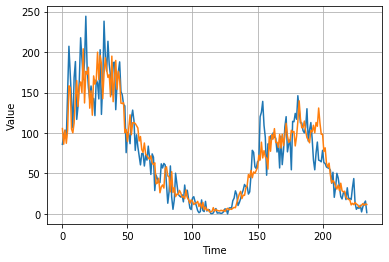

In [0]:
 lstmValidation(model,train, valid)
